# Batch Processing!
#### A notebook to show some of the capilities available through the BatchAnalysis package

This is certainly not an exhaustive look at everything that the BatchAnalysis module can do, but should hopefully provide some insight. 
...or, maybe I'm just procrastinating doing more useful work.

In [1]:
# Python Modules and instantiation
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import os
# %matplotlib widget
# ROSCO toolbox modules 
from ROSCO_toolbox import utilities as wtc_utilities
# WISDEM modules
from wisdem.aeroelasticse.Util import FileTools
# Batch Analysis tools
from BatchAnalysis import Processing, Analysis
from BatchAnalysis import pdTools

# Instantiate fast_IO
fast_io = wtc_utilities.FAST_IO()
fast_pl = wtc_utilities.FAST_Plots()

### Define file paths and filenames
I'm loading a case matrix output from using wisdem.aeroelasticse.CaseGen_General to run a series of batch runs to initialize the output files here. I'm just using some saved runs on my computer that are of no actual significants (and actually don't look great, but get the point accross).

In [2]:
# point to some file paths
outfile_base = '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/'
fname_case_matrix = '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/case_matrix.yaml'

In [3]:
# Load case matrix into datafraome
case_matrix = FileTools.load_yaml(fname_case_matrix, package=1)
cm = pd.DataFrame(case_matrix)
cm

,"(IEC, DLC)","(AeroDyn15, TwrAero)","(DISCON_in, Fl_Mode)","(DISCON_in, PS_Mode)","(ElastoDyn, BlPitch1)","(ElastoDyn, BlPitch2)","(ElastoDyn, BlPitch3)","(ElastoDyn, RotSpeed)","(Fst, OutFileFmt)","(Fst, TMax)","(InflowWind, Filename)","(InflowWind, WindType)","(ServoDyn, DLL_FileName)",Case_ID,Case_Name
0,1.1,True,0,0,0.000,0.000,0.000,7.506,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,0,5MW_Land_rosco_00
1,1.1,True,0,0,0.000,0.000,0.000,7.506,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,1,5MW_Land_rosco_01
2,1.1,True,0,0,0.000,0.000,0.000,7.942,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,2,5MW_Land_rosco_02
3,1.1,True,0,0,0.000,0.000,0.000,7.942,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,3,5MW_Land_rosco_03
4,1.1,True,0,0,0.000,0.000,0.000,8.469,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,4,5MW_Land_rosco_04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.3,True,0,0,14.920,14.920,14.920,12.100,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,59,5MW_Land_rosco_59
60,1.3,True,0,0,16.226,16.226,16.226,12.100,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,60,5MW_Land_rosco_60
61,1.3,True,0,0,16.226,16.226,16.226,12.100,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,61,5MW_Land_rosco_61
62,1.3,True,0,0,17.473,17.473,17.473,12.100,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,62,5MW_Land_rosco_62


In [4]:
# Define DLCs we care to separate things by
DLCs = [1.1, 1.3]

In [5]:
# Pare down case matrix for desired runs and load the outfiles
cm2 = pd.concat([cm[cm[('IEC','DLC')]==dlc].iloc[5:15] for dlc in DLCs]).reset_index()
# Parse find outfiles names
outfiles = []
for dlc in DLCs:
    case_names = cm2[cm2[('IEC','DLC')]==dlc]['Case_Name']
    outnames = list( outfile_base + case_names + '.outb' )
    outfiles.append(outnames)

#### `outfiles`
In the end, we just need a list of OpenFAST output files. Here, we have a structure that looks something like `[[], []]`. This could be extended any amount like `[[],[],...,[], []]`, or just be one list of strings `[]`.

In [6]:
outfiles

[['../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_05.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_06.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_07.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_08.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_09.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_10.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_11.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_12.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_13.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_14.outb'],
 ['../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_37.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_38.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_39.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_40.outb',
  '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_

### Now we can do some processing!

First, let's load the FAST_Processing class and initialize some parameters.


In [7]:
fp = Processing.FAST_Processing()
fp.OpenFAST_outfile_list = outfiles
fp.dataset_names = ['DLC1.1', 'DLC1.3']
fp.to = 30
fp.parallel_analysis = True
fp.save_LoadRanking = True
fp.save_SummaryStats = True
fp.verbose=False
fp.ranking_vars = [["RotSpeed"], 
                    ["OoPDefl1", "OoPDefl2", "OoPDefl3"], 
                    ['RootMxc1', 'RootMxc2', 'RootMxc3'],
                    ['TwrBsFyt'],
                    ] 

#### The fast way to compare things.
We could now collect all of the summary stats and load rankings using:
```
stats,load_rankings = fp.batch_processing()
```
In `fp.batch_processing()` most of the analysis is done for any structure of data. I'm going to step through things a bit more piecewise in this notebook, however.

In [8]:
# stats,load_rankings = fp.batch_processing()

### Design Comparisons
We can use fp.design_comparison to compare multiple sets of runs (like we are in this case...). This will generate summary stats and load rankings, running parralelizing when it can and is told to. `fp.batch_processing()` functionally does the same thing. We'll the design comparison here to show some speed-related results

In [9]:
t1 = time.time()
stats, load_ranking = fp.design_comparison(outfiles)
time.time() - t1

96.06093287467957

#### Breaking it down further...

`fp.batch_processing()` calls `Analysis.Loads_Analysls.full_loads_analysis()` to load openfast data, generate stats, and calculate load rankings. Because we defined `fp.parallel_analysis=True` this process was parallelized. This helps for speed and memory reasons, because now every openfast run is not saved. `fp.batch_processing()` then takes all of the output data and parses it back together. 

Separately, we call call `Analysis.Loads_Analysls.full_loads_analysis()` with `return_FastData=True` and all of the fast data will be returned. Because we are comparing data though, we'll stick with the design comparison tools.

### We can look at our data a bit further with pandas dataframes
The data here is just for three runs for simplicity. Usually you'd do this for a LOT more cases...

In [10]:
stats_df = pdTools.dict2df(stats, names=['DLC_1.1', 'DLC_1.3'])
stats_df.head()

DLC_1.1                                                               \
      Azimuth                                                                
          abs     integrated         max        mean       min         std   
0  359.998360  115610.344323  359.998360  179.916417  0.000000  103.915541   
1  359.987045   24235.239832  359.987045  179.635731  0.005493  103.898450   
2  359.998964   54802.558224  359.998964  179.675394  0.000000  103.846040   
3  359.995192  -85161.455250  359.995192  179.806159  0.005493  103.996468   
4  359.999055    1024.732815  359.999055  179.620563  0.000000  103.908648   

                                  ...      DLC_1.3                           \
  B1N3Clrnc                       ...     YawBrMyp                            
        abs integrated  max mean  ...          max        mean          min   
0       0.0        0.0  0.0  0.0  ...  5687.967853 -383.981929 -6622.069859   
1       0.0        0.0  0.0  0.0  ...  6835.267255 -170.899320 -5847.118306   
2       0.0        0.0  0.0  0.0  ...  6288.900086 -169.509745 -7101.736067   
3       0.0        0.0  0.0  0.0  ...  6984.862206  -24.107531 -6495.954246   
4       0.0        0.0  0.0  0.0  ...  6433.094034   20.726053 -7605.192051   

                                                                    \
                   YawBrMzp                                          
           std          abs    integrated          max        mean   
0  1737.069191  8579.990130  1.621373e+06  8579.990130  187.334028   
1  1964.130974  7692.643524 -3.211141e+05  6887.358303 -109.329875   
2  1877.098958  8227.908823  8.690936e+05  8227.908823  198.247817   
3  2101.079696  7995.033787 -4.419405e+06  7995.033787 -132.119173   
4  1990.950649  8782.596164  8.610109e+05  8782.596164  186.059848   

                             
                             
           min          std  
0 -6780.452776  2055.357993  
1 -7692.643524  1970.066781  
2 -6998.702585  2200.745797  
3 -7752.051099  2119.468573  
4 -6747.106181  2338.962718  

[5 rows x 1296 columns]

### Load Ranking
Lets re-run the load ranking for the sake of example. We'll have to load the analysis tools, and then run the load ranking for the stats we just got. 

In [11]:
fa = Analysis.Loads_Analysis()
fa.t0 = 30
fa.verbose = False

In [12]:
isinstance(stats_df,pd.DataFrame)

True

Define the ranking variables and statiscits of interest. Note that `len(ranking_vars) == len(ranking_stats)`! We can pass this a list of stats (multiple runs), a dictionary with one run of stats, or a pandas dataframe with the requisite stats. We'll also output a dictionary and a pandas DataFrame from `fa.load_ranking()`

In [13]:
ranking_vars = [['TwrBsFxt'], ['OoPDefl1', 'OoPDefl2', 'OoPDefl3']]
ranking_stats = ['max', 'max']
load_ranking, load_ranking_df = fa.load_ranking(stats_df, ranking_stats, ranking_vars, get_df=True)
load_ranking_df.head()

DLC_1.1                                          DLC_1.3               \
    OoPDefl                   TwrBsFx                OoPDefl                
        max max_case_idx          max max_case_idx       max max_case_idx   
0  7.716517            7  1878.898899            7  9.100879            8   
1  7.435798            8  1775.758615            9  8.497827            7   
2  7.209455            9  1661.138297            5  8.496903            9   
3  7.174903            5  1415.800448            8  8.492588            5   
4  7.118868            3  1396.057606            3  8.487301            6   

                             
       TwrBsFx               
           max max_case_idx  
0  2108.355009            7  
1  2027.430900            9  
2  1978.243697            5  
3  1652.299369            3  
4  1481.976429            8

This is organized for each iteration of `[ranking_vars, ranking_stats]`. The stats are ordered accordingly, and `(stat)_case_idx` refers to the case name index of each load. 

### Wind speed related analysis
We often want to make sense of some batch output data with data binned by windspeed. We can leverage the case-matrix from our output data to figure out the input wind speeds. Of course, `('InflowWind', 'Filename')` must exist in the case matrix. Lets load the wind speeds, save them, and append them to the case matrix as `('InflowWind', 'WindSpeed')`.

In [14]:
windspeed, seed, IECtype, cmw = Processing.get_windspeeds(cm2, return_df=True)
cmw.head()

,index,"(IEC, DLC)","(AeroDyn15, TwrAero)","(DISCON_in, Fl_Mode)","(DISCON_in, PS_Mode)","(ElastoDyn, BlPitch1)","(ElastoDyn, BlPitch2)","(ElastoDyn, BlPitch3)","(ElastoDyn, RotSpeed)","(Fst, OutFileFmt)","(Fst, TMax)","(InflowWind, Filename)","(InflowWind, WindType)","(ServoDyn, DLL_FileName)",Case_ID,Case_Name,"(InflowWind, WindSpeed)","(InflowWind, Seed)","(InflowWind, IECtype)"
0,5,1.1,True,0,0,0.0,0.0,0.0,8.469,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,5,5MW_Land_rosco_05,7.0,12345.0,NTM
1,6,1.1,True,0,0,0.0,0.0,0.0,9.156,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,6,5MW_Land_rosco_06,8.0,54321.0,NTM
2,7,1.1,True,0,0,0.0,0.0,0.0,9.156,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,7,5MW_Land_rosco_07,8.0,12345.0,NTM
3,8,1.1,True,0,0,0.0,0.0,0.0,10.296,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,8,5MW_Land_rosco_08,9.0,54321.0,NTM
4,9,1.1,True,0,0,0.0,0.0,0.0,10.296,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,9,5MW_Land_rosco_09,9.0,12345.0,NTM


#### AEP
Now that we know the wind speeds that we were operating at, we can find the AEP. 

In [15]:
pp = Analysis.Power_Production()
Vavg = 10 # Averag e wind speed of cite
Vrange = [2,26] # Range of wind speeds being considered
bnums = int(len(windspeed)/len(fp.dataset_names)) # Number of wind speeds per dataset for binning data
pp.windspeeds = list(set(windspeed))
p = pp.gen_windPDF(Vavg, bnums, Vrange)
AEP = pp.AEP(stats)
print('AEP = {}'.format(AEP))

AEP = [19883012.24116963 21122666.10902583]


### Plotting
Finally, we can make some plots. There are a few tools we have at our disposal here. First, we can look at more plots that show our design performance as a function of wind speed. Notably, we can pass the stats dictionary or dataframe to these statistics-related scripts.

Currently, `an_plts.stat_curve()` can plot a "statistics curve" for of two types, a bar or a line graph. 

A bar graph is useful to compare design cases easily:

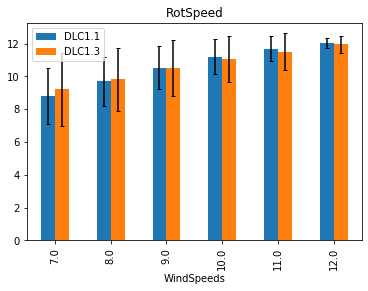

In [16]:
plt.close()
an_plts = Analysis.wsPlotting()
an_plts.stat_curve(windspeed, stats, 'RotSpeed', 'bar', names=['DLC1.1', 'DLC1.3'])
plt.show()

A line graph can be useful to show turbulent wind curves. Here we show the means with a first level of errorbars corresponding to standard deviations, and a second level showing minimums and maximums.

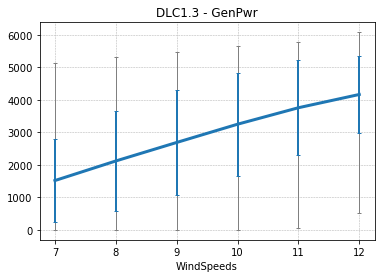

In [17]:
an_plts.stat_curve(windspeed, stats, 'GenPwr', 'line', stat_idx=1, names=['DLC1.3'])
plt.show()

#### Time domain related data
We can also look at our data from the time domain results. 

We can compare any number of channels using the ROSCO toolbox plotting tools. First we'll load two cases to plot together, then plot the time histories.

In [18]:
#  Load some time domain cases 
filenames = [outfiles[0][2], outfiles[1][2]] # select the 2nd run from each dataset
fast_data = fast_io.load_FAST_out(filenames, tmin=30)
filenames

['../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_07.outb',
 '../BatchOutputs/5MW_Land/5MW_Land_ROSCO/5MW_Land_rosco_39.outb']

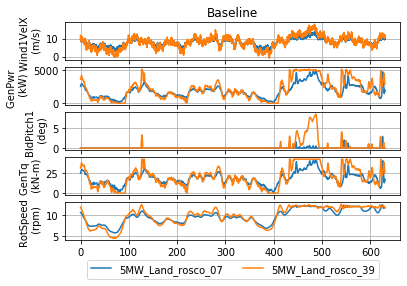

In [19]:
# Define the plots we want to make (can be as many or as few channels and plots as you would like...)
cases = {'Baseline': ['Wind1VelX', 'GenPwr', 'BldPitch1', 'GenTq', 'RotSpeed']}

# plot
fast_pl.plot_fast_out(cases, fast_data)
plt.show()

We can additionally do some frequency domain analysis. Here, `spec_cases` is defined by `(channel, run)` where the run index corresponds to the desired plotting index in the loaded fast data.

[WARN] dt from tmax-tmin different from dt from t2-t1
[WARN] dt from tmax-tmin different from dt from t2-t1


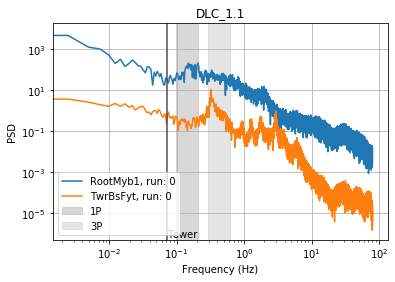

In [20]:
spec_cases = [('RootMyb1', 0), ('TwrBsFyt', 0)]
twrfreq = .0716
fig, ax = fast_pl.plot_spectral(fast_data, spec_cases, 
                                show_RtSpeed=True, RtSpeed_idx=[0],
                                add_freqs=[twrfreq], add_freq_labels=['Tower'],
                                averaging='Welch')
ax.set_title('DLC_1.1')
plt.show()

Finally, we can plot the distribution of any channels from our fast output data

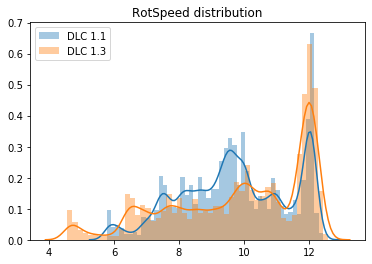

In [22]:
an_plts = Analysis.wsPlotting()
channels = ['RotSpeed']
caseid = [0,1]
an_plts.distribution(fast_data, channels, caseid, names=['DLC 1.1', 'DLC 1.3'])
plt.show()